In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
NUM_CLASSES = 31
BATCH_SIZE = 32
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
STEP_SIZE = 20
GAMMA = 0.1
NUM_EPOCHS = 10
ALPHA = 0.25

In [3]:
# Define Reverse Layer Function
class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

# Define the ResNetDANN Model
class ResNetDANN(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNetDANN, self).__init__()
        self.feature_extractor = models.resnet50(pretrained=pretrained)
        self.feature_extractor.fc = nn.Identity()

        self.class_classifier = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x, alpha=None):
        features = self.feature_extractor(x)
        if alpha is not None:
            reverse_features = ReverseLayerF.apply(features, alpha)
            domain_out = self.domain_classifier(reverse_features)
            return domain_out
        else:
            class_out = self.class_classifier(features)
            return class_out

In [4]:
# Training Function
def train_model(source_loader, target_loader, model, criterion, optimizer, scheduler, num_epochs, alpha):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        # print(f"--- Epoch {epoch + 1}/{num_epochs}, LR = {scheduler.get_last_lr()}")

        for (source_images, source_labels), (target_images, _) in zip(source_loader, target_loader):
            source_images, source_labels = source_images.to(device), source_labels.to(device)
            target_images = target_images.to(device)

            optimizer.zero_grad()

            # Classifier training
            class_outputs = model(source_images)
            loss_class = criterion(class_outputs, source_labels)

            # Domain adaptation
            domain_source = model(source_images, alpha=alpha)
            domain_target = model(target_images, alpha=alpha)

            labels_source = torch.zeros(domain_source.size(0), dtype=torch.long).to(device)
            labels_target = torch.ones(domain_target.size(0), dtype=torch.long).to(device)

            loss_discr_source = criterion(domain_source, labels_source)
            loss_discr_target = criterion(domain_target, labels_target)

            total_loss = loss_class + loss_discr_source + loss_discr_target
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item() * source_images.size(0)
            _, preds = torch.max(class_outputs, 1)
            running_corrects += torch.sum(preds == source_labels).item()
            total_samples += source_images.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = (running_corrects / total_samples) * 100

        print(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f}             Accuracy: {epoch_acc:.4f}")
        scheduler.step()

In [15]:
def visualize_features(source_loader, target_loader, model, comb,subset_size=1000):
    model.eval()

    source_features, target_features = [], []

    with torch.no_grad():
        for images, _ in source_loader:
            images = images.to(device)
            features = model.feature_extractor(images).cpu().numpy()
            source_features.append(features)

        for images, _ in target_loader:
            images = images.to(device)
            features = model.feature_extractor(images).cpu().numpy()
            target_features.append(features)

    source_features = np.concatenate(source_features, axis=0)
    target_features = np.concatenate(target_features, axis=0)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    source_tsne = tsne.fit_transform(source_features[:subset_size])
    target_tsne = tsne.fit_transform(target_features[:subset_size])

    plt.figure(figsize=(10, 8))
    plt.scatter(source_tsne[:, 0], source_tsne[:, 1], color="blue", label=comb[0], alpha=0.7)
    plt.scatter(target_tsne[:, 0], target_tsne[:, 1], color="red", label=comb[1], alpha=0.7)
    plt.title("Feature Distributions (t-SNE)")
    plt.legend()
    plt.show()

In [6]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    return (correct / total) * 100

In [11]:
def load_office31_dataset(domain, batch_size):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    dataset_path = f"/kaggle/input/office31/Office-31/{domain}"  # Update with your dataset path structure
    dataset = datasets.ImageFolder(dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    return loader

In [16]:
def run_this_shit(domain_combinations):
    for source, target in domain_combinations:
        print(f"\nTraining Source: {source}, Target: {target}")

        source_loader = load_office31_dataset(source, BATCH_SIZE)
        target_loader = load_office31_dataset(target, BATCH_SIZE)

        model = ResNetDANN(NUM_CLASSES).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

        # print("Feature Visualization Before Training")
        # visualize_features(source_loader, target_loader, model)

        train_model(source_loader, target_loader, model, criterion, optimizer, scheduler, NUM_EPOCHS, ALPHA)

        source_acc = evaluate_model(model, source_loader)
        target_acc = evaluate_model(model, target_loader)
        drop = ((source_acc - target_acc) / source_acc) * 100
        
        print(f"Source Accuracy: {source_acc:.2f}%")
        print(f"Target Accuracy: {target_acc:.2f}%")
        print(f"Drop: {drop:.2f}%")
        print("Feature Visualization After Training")
        visualize_features(source_loader, target_loader, model, [source, target])


Training Source: amazon, Target: dslr


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Loss: 4.8275             Accuracy: 3.3203
Epoch 2 Loss: 4.7616             Accuracy: 8.3984
Epoch 3 Loss: 4.6733             Accuracy: 14.6484
Epoch 4 Loss: 4.5875             Accuracy: 24.4141
Epoch 5 Loss: 4.4798             Accuracy: 30.2734
Epoch 6 Loss: 4.3142             Accuracy: 37.5000
Epoch 7 Loss: 4.1656             Accuracy: 42.9688
Epoch 8 Loss: 4.0158             Accuracy: 47.2656
Epoch 9 Loss: 3.8037             Accuracy: 54.1016
Epoch 10 Loss: 3.6180             Accuracy: 55.8594
Source Accuracy: 70.11%
Target Accuracy: 59.44%
Drop: 15.22%
Feature Visualization After Training


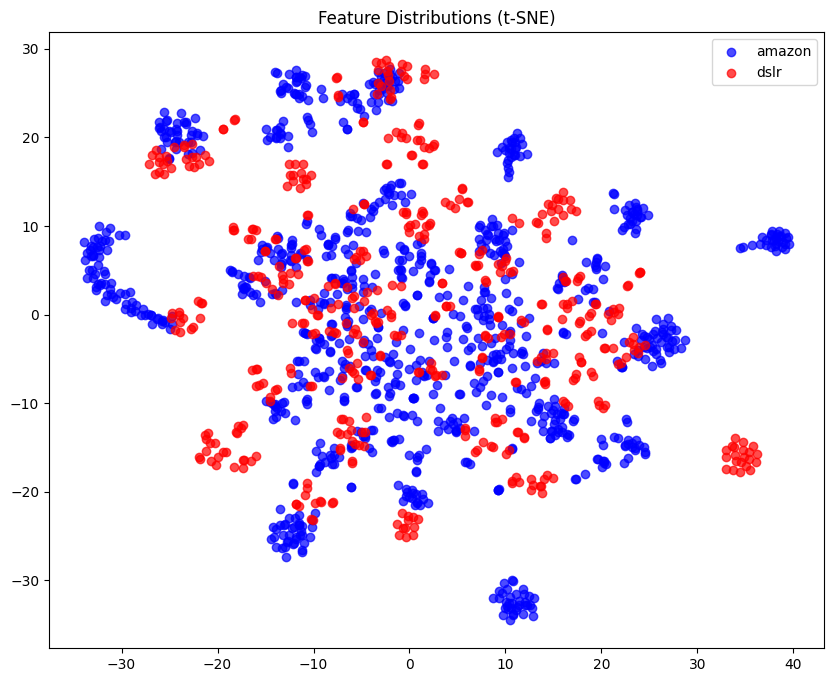

In [17]:
# Example Usage
domain_combinations = [
    ("amazon", "dslr")
    # ("amazon", "webcam"),
    # ("dslr", "amazon"),
    # ("dslr", "webcam"),
    # ("webcam", "amazon"),
    # ("webcam", "dslr"),
]

run_this_shit(domain_combinations)


Training Source: amazon, Target: webcam


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Loss: 4.8072             Accuracy: 6.0000
Epoch 2 Loss: 4.6853             Accuracy: 14.7500
Epoch 3 Loss: 4.5457             Accuracy: 22.7500
Epoch 4 Loss: 4.3427             Accuracy: 38.7500
Epoch 5 Loss: 4.0778             Accuracy: 46.6250
Epoch 6 Loss: 3.7409             Accuracy: 53.7500
Epoch 7 Loss: 3.4003             Accuracy: 60.2500
Epoch 8 Loss: 3.1716             Accuracy: 62.0000
Epoch 9 Loss: 2.8070             Accuracy: 70.8750
Epoch 10 Loss: 2.6321             Accuracy: 72.0000
Source Accuracy: 78.91%
Target Accuracy: 65.16%
Drop: 17.43%
Feature Visualization After Training


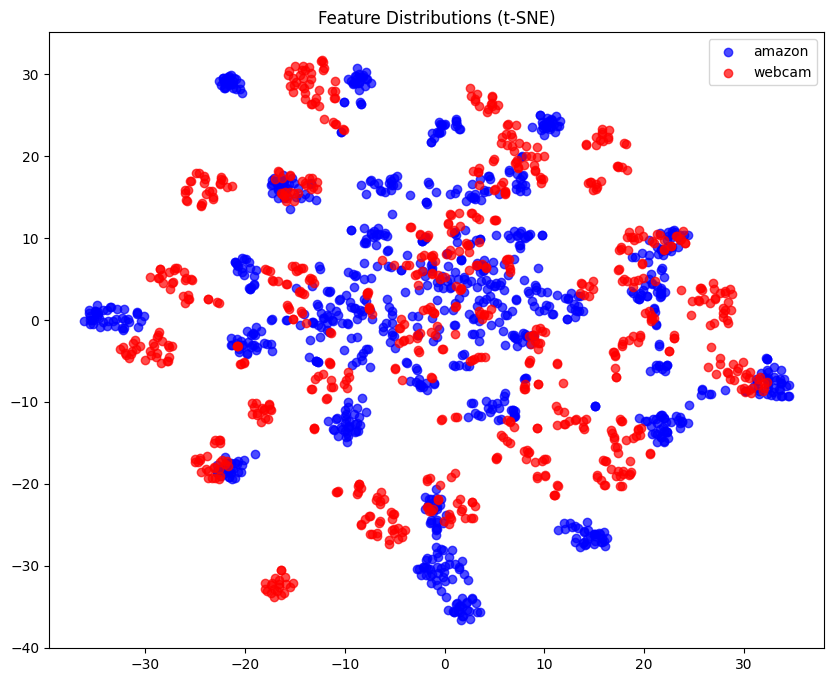

In [18]:
# Example Usage
domain_combinations = [
    # ("amazon", "dslr")
    ("amazon", "webcam")
    # ("dslr", "amazon"),
    # ("dslr", "webcam"),
    # ("webcam", "amazon"),
    # ("webcam", "dslr"),
]

run_this_shit(domain_combinations)

# DSLR


Training Source: dslr, Target: amazon


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Loss: 4.8080             Accuracy: 6.6265
Epoch 2 Loss: 4.6646             Accuracy: 17.6707
Epoch 3 Loss: 4.5202             Accuracy: 23.2932
Epoch 4 Loss: 4.3154             Accuracy: 33.7349
Epoch 5 Loss: 4.0674             Accuracy: 41.7671
Epoch 6 Loss: 3.7703             Accuracy: 52.0080
Epoch 7 Loss: 3.4986             Accuracy: 57.4297
Epoch 8 Loss: 3.2127             Accuracy: 66.0643
Epoch 9 Loss: 2.9180             Accuracy: 73.0924
Epoch 10 Loss: 2.6646             Accuracy: 78.1124
Source Accuracy: 89.96%
Target Accuracy: 43.98%
Drop: 51.11%
Feature Visualization After Training


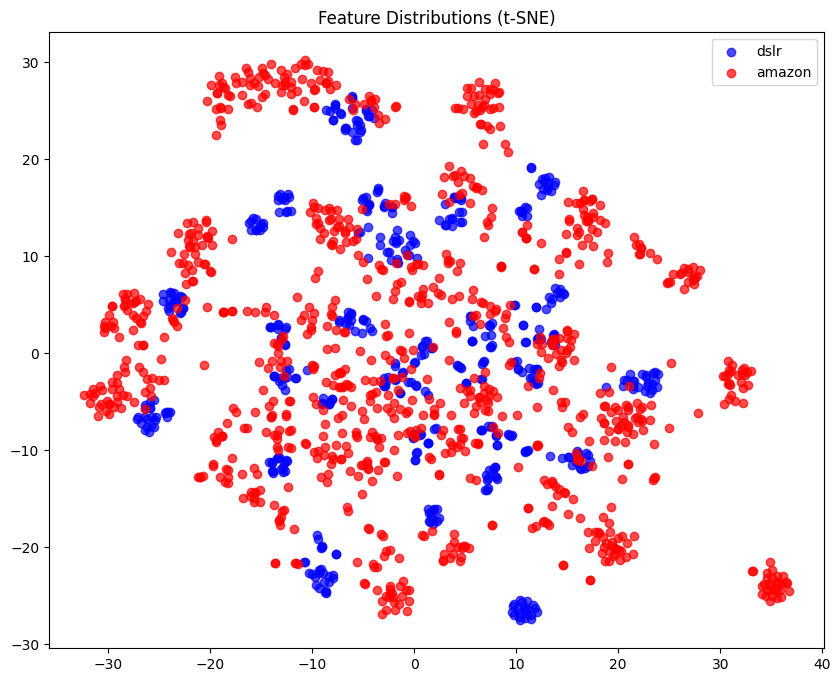

In [19]:
domain_combinations = [
    # ("amazon", "dslr"),
    # ("amazon", "webcam"),
    ("dslr", "amazon")
    # ("dslr", "webcam"),
    # ("webcam", "amazon"),
    # ("webcam", "dslr"),
]

run_this_shit(domain_combinations)


Training Source: dslr, Target: webcam


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Loss: 4.8151             Accuracy: 4.6185
Epoch 2 Loss: 4.6772             Accuracy: 15.6627
Epoch 3 Loss: 4.5033             Accuracy: 32.5301
Epoch 4 Loss: 4.2959             Accuracy: 41.1647
Epoch 5 Loss: 4.0645             Accuracy: 46.7871
Epoch 6 Loss: 3.7674             Accuracy: 56.8273
Epoch 7 Loss: 3.5207             Accuracy: 58.4337
Epoch 8 Loss: 3.2331             Accuracy: 69.4779
Epoch 9 Loss: 2.9529             Accuracy: 75.9036
Epoch 10 Loss: 2.7134             Accuracy: 78.3133
Source Accuracy: 92.37%
Target Accuracy: 75.47%
Drop: 18.29%
Feature Visualization After Training


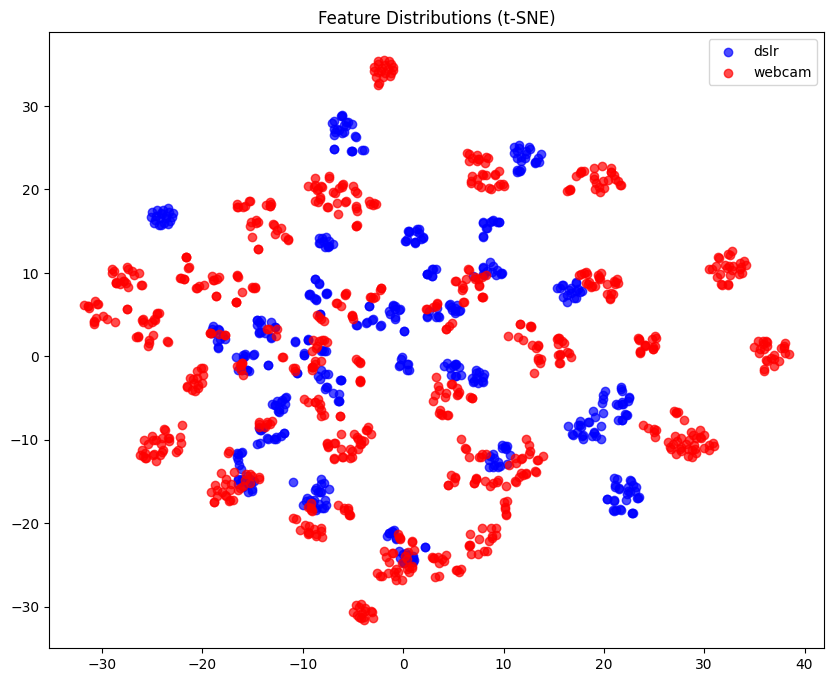

In [20]:
# Example Usage
domain_combinations = [
    # ("amazon", "dslr"),
    # ("amazon", "webcam"),
    # ("dslr", "amazon"),
    ("dslr", "webcam")
    # ("webcam", "amazon"),
    # ("webcam", "dslr"),
]

run_this_shit(domain_combinations)

# Webcam


Training Source: webcam, Target: amazon


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Loss: 4.7909             Accuracy: 6.7925
Epoch 2 Loss: 4.5824             Accuracy: 20.3774
Epoch 3 Loss: 4.3190             Accuracy: 35.3459
Epoch 4 Loss: 3.9810             Accuracy: 48.9308
Epoch 5 Loss: 3.5536             Accuracy: 61.8868
Epoch 6 Loss: 3.1314             Accuracy: 71.0692
Epoch 7 Loss: 2.7102             Accuracy: 79.1195
Epoch 8 Loss: 2.3804             Accuracy: 83.5220
Epoch 9 Loss: 2.1037             Accuracy: 88.9308
Epoch 10 Loss: 1.8526             Accuracy: 92.3270
Source Accuracy: 96.86%
Target Accuracy: 57.40%
Drop: 40.73%
Feature Visualization After Training


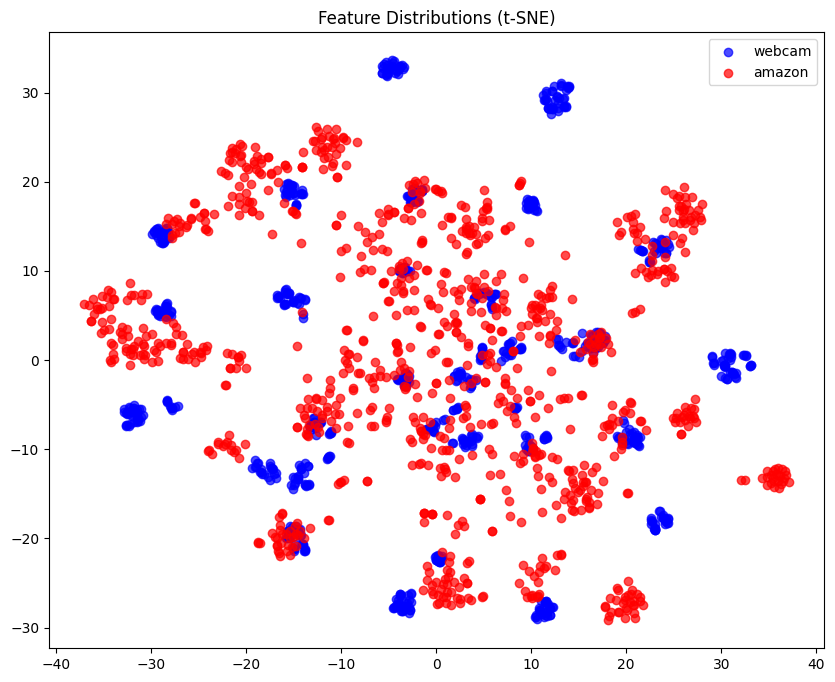

In [21]:
# Example Usage
domain_combinations = [
    # ("amazon", "dslr"),
    # ("amazon", "webcam"),
    # ("dslr", "amazon"),
    # ("dslr", "webcam"),
    ("webcam", "amazon")
    # ("webcam", "dslr"),
]

run_this_shit(domain_combinations)


Training Source: webcam, Target: dslr


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Loss: 4.8083             Accuracy: 4.1016
Epoch 2 Loss: 4.6956             Accuracy: 13.2812
Epoch 3 Loss: 4.5614             Accuracy: 27.7344
Epoch 4 Loss: 4.3754             Accuracy: 35.3516
Epoch 5 Loss: 4.1753             Accuracy: 45.7031
Epoch 6 Loss: 3.9415             Accuracy: 50.5859
Epoch 7 Loss: 3.6640             Accuracy: 59.9609
Epoch 8 Loss: 3.4087             Accuracy: 64.8438
Epoch 9 Loss: 3.1207             Accuracy: 70.1172
Epoch 10 Loss: 2.9088             Accuracy: 75.5859
Source Accuracy: 84.65%
Target Accuracy: 75.70%
Drop: 10.57%
Feature Visualization After Training


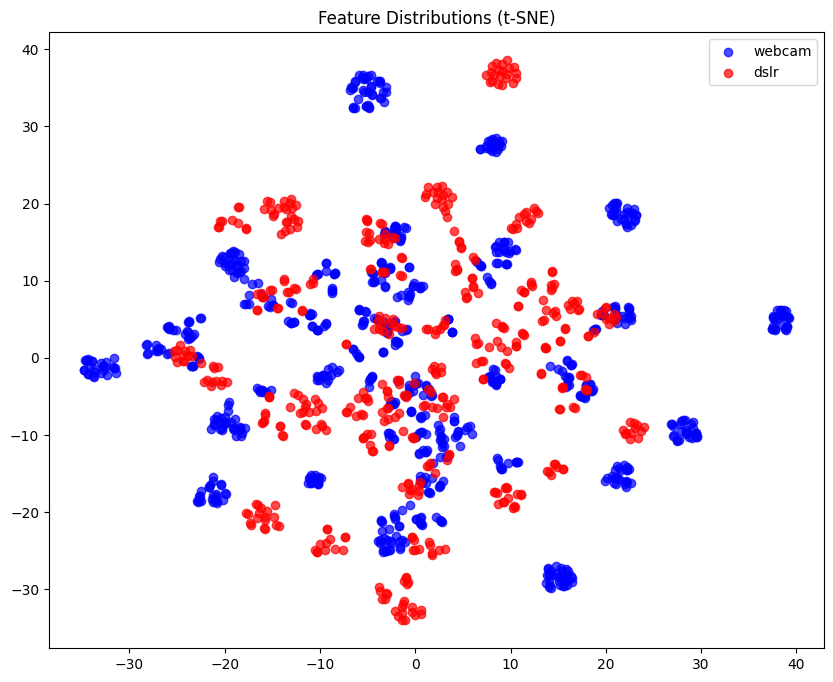

In [22]:
# Example Usage
domain_combinations = [
    # ("amazon", "dslr"),
    # ("amazon", "webcam"),
    # ("dslr", "amazon"),
    # ("dslr", "webcam"),
    # ("webcam", "amazon"),
    ("webcam", "dslr")
]

run_this_shit(domain_combinations)

# IGNORE

In [27]:
# Dataset Loading for Digits (MNIST, USPS, SVHN)
def load_digits_dataset(source_domain, target_domain, batch_size=32, subset_size=1000):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
    }

    dataset_mapping = {
        'MNIST': lambda train: datasets.MNIST(root="./data", train=train, download=True, transform=data_transforms['train' if train else 'val']),
        'USPS': lambda train: datasets.USPS(root="./data", train=train, download=True, transform=data_transforms['train' if train else 'val']),
        'SVHN': lambda train: datasets.SVHN(root="./data", split='train' if train else 'test', download=True, transform=data_transforms['train' if train else 'val'])
    }

    if source_domain not in dataset_mapping or target_domain not in dataset_mapping:
        raise ValueError("Invalid domain. Supported domains are: MNIST, USPS, SVHN")

    source_dataset = dataset_mapping[source_domain](train=True)
    target_dataset = dataset_mapping[target_domain](train=False)

    if subset_size:
        source_indices = random.sample(range(len(source_dataset)), subset_size)
        target_indices = random.sample(range(len(target_dataset)), subset_size)
        source_dataset = Subset(source_dataset, source_indices)
        target_dataset = Subset(target_dataset, target_indices)

    source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return source_loader, target_loader

In [54]:
# Main Pipeline
def run_pipeline(domain_combinations, dataset_loader):
    for source, target in domain_combinations:
        print(f"\nTraining Source: {source}, Target: {target}")

        source_loader, target_loader = dataset_loader(source, target, BATCH_SIZE)

        model = ResNetDANN(NUM_CLASSES).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

        train_model(source_loader, target_loader, model, criterion, optimizer, scheduler, NUM_EPOCHS, ALPHA)

        source_acc = evaluate_model(model, source_loader)
        target_acc = evaluate_model(model, target_loader)
        drop = ((source_acc - target_acc) / source_acc) * 100

        print(f"Source Accuracy: {source_acc:.2f}%")
        print(f"Target Accuracy: {target_acc:.2f}%")
        print(f"Drop: {drop:.2f}%")

In [36]:

# Example Usage for Digits Dataset
digits_domain_combinations = [
    # ("MNIST", "USPS"),
    ("MNIST", "SVHN")
    # ("USPS", "MNIST"),
    # ("USPS", "SVHN"),
    # ("SVHN", "MNIST"),
    # ("SVHN", "USPS"),
]

run_pipeline(digits_domain_combinations, load_digits_dataset)


Training Source: MNIST, Target: SVHN
Using downloaded and verified file: ./data/test_32x32.mat
Epoch 1 Loss: 4.5243             Accuracy: 12.2000
Epoch 2 Loss: 3.3811             Accuracy: 41.6000
Epoch 3 Loss: 2.3711             Accuracy: 74.2000
Epoch 4 Loss: 1.7766             Accuracy: 89.9000
Epoch 5 Loss: 1.5284             Accuracy: 93.2000
Epoch 6 Loss: 1.3670             Accuracy: 94.9000
Epoch 7 Loss: 1.3892             Accuracy: 93.9000
Epoch 8 Loss: 1.2718             Accuracy: 96.1000
Epoch 9 Loss: 1.2680             Accuracy: 95.9000
Epoch 10 Loss: 1.2575             Accuracy: 95.7000
Source Accuracy: 99.00%
Target Accuracy: 71.11%
Drop: 28.17%


In [38]:

# Example Usage for Digits Dataset
digits_domain_combinations = [
    ("MNIST", "USPS")
    # ("MNIST", "SVHN"),
    # ("USPS", "MNIST"),
    # ("USPS", "SVHN"),
    # ("SVHN", "MNIST"),
    # ("SVHN", "USPS"),
]

run_pipeline(digits_domain_combinations, load_digits_dataset)


Training Source: MNIST, Target: USPS
Epoch 1 Loss: 4.4950             Accuracy: 14.0000
Epoch 2 Loss: 3.4747             Accuracy: 33.0000
Epoch 3 Loss: 2.6333             Accuracy: 66.5000
Epoch 4 Loss: 1.9939             Accuracy: 84.8000
Epoch 5 Loss: 1.6749             Accuracy: 91.8000
Epoch 6 Loss: 1.5724             Accuracy: 93.7000
Epoch 7 Loss: 1.4871             Accuracy: 96.0000
Epoch 8 Loss: 1.4840             Accuracy: 96.7000
Epoch 9 Loss: 1.4663             Accuracy: 96.3000
Epoch 10 Loss: 1.4687             Accuracy: 96.1000
Source Accuracy: 94.40%
Target Accuracy: 75.20%
Drop: 20.34%


In [55]:

# Example Usage for Digits Dataset
digits_domain_combinations = [
    # ("MNIST", "USPS"),
    # ("MNIST", "SVHN"),
    # ("USPS", "MNIST"),
    # ("USPS", "SVHN"),
    ("SVHN", "MNIST")
    # ("SVHN", "USPS"),
]

run_pipeline(digits_domain_combinations, load_digits_dataset)


Training Source: SVHN, Target: MNIST
Using downloaded and verified file: ./data/train_32x32.mat
Epoch 1 Loss: 4.4348             Accuracy: 15.2000
Epoch 2 Loss: 3.7915             Accuracy: 20.1000
Epoch 3 Loss: 3.5722             Accuracy: 23.7000
Epoch 4 Loss: 3.3460             Accuracy: 32.2000
Epoch 5 Loss: 3.1224             Accuracy: 41.4000
Epoch 6 Loss: 2.8940             Accuracy: 46.7000
Epoch 7 Loss: 2.6683             Accuracy: 56.9000
Epoch 8 Loss: 2.4258             Accuracy: 65.0000
Epoch 9 Loss: 2.2118             Accuracy: 71.6000
Epoch 10 Loss: 2.0890             Accuracy: 76.8000
Source Accuracy: 57.20%
Target Accuracy: 49.22%
Drop: 13.95%


In [52]:
# Example Usage for Digits Dataset
digits_domain_combinations = [
    # ("MNIST", "USPS"),
    # ("MNIST", "SVHN"),
    # ("USPS", "MNIST"),
    # ("USPS", "SVHN"),
    # ("SVHN", "MNIST"),
    ("SVHN", "USPS")
]

run_pipeline(digits_domain_combinations, load_digits_dataset)


Training Source: SVHN, Target: USPS
Using downloaded and verified file: ./data/train_32x32.mat
Epoch 1 Loss: 4.5807             Accuracy: 12.4000
Epoch 2 Loss: 3.9121             Accuracy: 20.0000
Epoch 3 Loss: 3.6050             Accuracy: 24.1000
Epoch 4 Loss: 3.3813             Accuracy: 30.6000
Epoch 5 Loss: 3.1528             Accuracy: 38.4000
Epoch 6 Loss: 2.8831             Accuracy: 47.1000
Epoch 7 Loss: 2.5651             Accuracy: 59.0000
Epoch 8 Loss: 2.3544             Accuracy: 68.1000
Epoch 9 Loss: 2.1693             Accuracy: 73.2000
Epoch 10 Loss: 2.0271             Accuracy: 76.6000
Source Accuracy: 72.60%
Target Accuracy: 64.16%
Drop: 11.63%


In [41]:
# Example Usage for Digits Dataset
digits_domain_combinations = [
    # ("MNIST", "USPS"),
    # ("MNIST", "SVHN"),
    ("USPS", "MNIST")
    # ("USPS", "SVHN"),
    # ("SVHN", "MNIST"),
    # ("SVHN", "USPS"),
]

run_pipeline(digits_domain_combinations, load_digits_dataset)


Training Source: USPS, Target: MNIST


100%|██████████| 6579383/6579383 [00:03<00:00, 1689232.20it/s]


Epoch 1 Loss: 4.4438             Accuracy: 18.2000
Epoch 2 Loss: 3.2154             Accuracy: 46.2000
Epoch 3 Loss: 2.4574             Accuracy: 71.3000
Epoch 4 Loss: 1.9242             Accuracy: 87.9000
Epoch 5 Loss: 1.6075             Accuracy: 93.3000
Epoch 6 Loss: 1.4798             Accuracy: 96.1000
Epoch 7 Loss: 1.4637             Accuracy: 96.3000
Epoch 8 Loss: 1.4600             Accuracy: 96.2000
Epoch 9 Loss: 1.4448             Accuracy: 96.9000
Epoch 10 Loss: 1.4064             Accuracy: 98.5000
Source Accuracy: 99.40%
Target Accuracy: 76.00%
Drop: 23.54%


In [46]:

# Example Usage for Digits Dataset
digits_domain_combinations = [
    # ("MNIST", "USPS"),
    # ("MNIST", "SVHN"),
    # ("USPS", "MNIST"),
    ("USPS", "SVHN")
    # ("SVHN", "MNIST"),
    # ("SVHN", "USPS"),
]

run_pipeline(digits_domain_combinations, load_digits_dataset)


Training Source: USPS, Target: SVHN
Using downloaded and verified file: ./data/test_32x32.mat
Epoch 1 Loss: 4.4709             Accuracy: 16.7000
Epoch 2 Loss: 3.3631             Accuracy: 40.5000
Epoch 3 Loss: 2.4485             Accuracy: 68.5000
Epoch 4 Loss: 1.8209             Accuracy: 87.1000
Epoch 5 Loss: 1.5181             Accuracy: 93.2000
Epoch 6 Loss: 1.3418             Accuracy: 95.6000
Epoch 7 Loss: 1.2305             Accuracy: 96.8000
Epoch 8 Loss: 1.1401             Accuracy: 98.1000
Epoch 9 Loss: 1.1711             Accuracy: 97.5000
Epoch 10 Loss: 1.2154             Accuracy: 97.6000
Source Accuracy: 99.90%
Target Accuracy: 84.16%
Drop: 15.76%
